In [1]:
import os
import pandas as pd
import geopandas as gpd

import rasterio

import pystac_client
import planetary_computer as pc

import lidar_sampling_functions as lsf

In [2]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

#campus point 2018 naip scene
itemid = 'ca_m_3411934_sw_11_060_20180722_20190209'
search = catalog.search(
    collections=["naip"],
    ids = itemid
)
item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
ds.crs

CRS.from_epsg(26911)

In [3]:
fp = '/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/points_from_naip_images/campus_lagoon_points/campus_lagoon_points_2018.csv'
pts = lsf.geodataframe_from_csv(fp, ds.crs)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [4]:
pts.head(3)

,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry
0,1,93,88,93,141,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.430 3810848.805)
1,1,85,85,89,137,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.547 3810846.093)
2,1,89,85,91,133,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238344.864 3810845.535)


In [6]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
lidar_rast_r = rasterio.open(fp)

In [8]:
# lsf.save_min_max_diff_rasters(lidar_rast_r, os.getcwd())
# lsf.save_avg_rasters(lidar_rast_r, os.getcwd())

In [9]:
pts_xy = lsf.pts_for_lidar_sampling(pts, lidar_rast_r.crs)

In [10]:
lidar_samples = lsf.sample_raster(pts_xy, lidar_rast_r)

In [11]:
fp = os.path.join(os.getcwd(),'lidar_maxs.tif')
maxs_rast_r = rasterio.open(fp)
max_samples = lsf.sample_raster(pts_xy, maxs_rast_r)

In [12]:
fp = os.path.join(os.getcwd(),'lidar_mins.tif')
mins_rast_r = rasterio.open(fp)
min_samples = lsf.sample_raster(pts_xy, mins_rast_r)

In [13]:
fp = os.path.join(os.getcwd(),'lidar_avgs.tif')
avg_rast_r = rasterio.open(fp)
avg_samples = lsf.sample_raster(pts_xy, avg_rast_r)

In [14]:
pts['lidar'] = lidar_samples
pts['max_lidar_w']= max_samples
pts['min_lidar_w'] = min_samples
pts['min_max_diff'] = pts.max_lidar_w - pts.min_lidar_w
pts['avg_lidar_w'] = avg_samples


In [15]:
pts.head(3)

,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w
0,1,93,88,93,141,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.430 3810848.805),4,5,2,3,3.333333
1,1,85,85,89,137,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.547 3810846.093),4,5,2,3,3.333333
2,1,89,85,91,133,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238344.864 3810845.535),4,5,2,3,3.333333


In [16]:
pts.to_csv(os.path.join(os.getcwd(),'campus_lagoon_2018_lidar.csv'))

## Some stats

In [14]:
ice = pts.loc[pts.iceplant==1]
nonice = pts.loc[pts.iceplant==0]

In [15]:
ice.lidar.value_counts()

2     2311
1     1636
0      990
3      498
4      260
11     192
5      175
16     110
12     108
8       76
7       42
13      27
6       16
14       8
Name: lidar, dtype: int64

<AxesSubplot:ylabel='Frequency'>

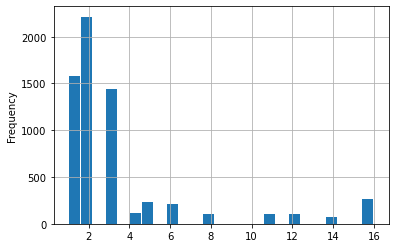

In [16]:
ice.min_max_diff.plot.hist(grid=True, bins=25, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

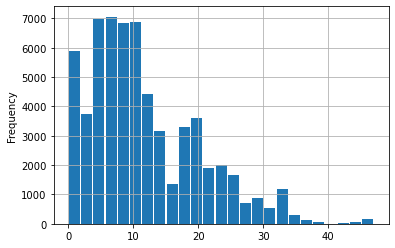

In [17]:
nonice.min_max_diff.plot.hist(grid=True, bins=25, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

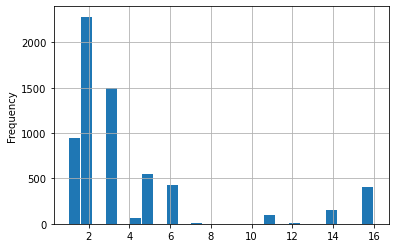

In [18]:
ice.max_lidar_w.plot.hist(grid=True, bins=25, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

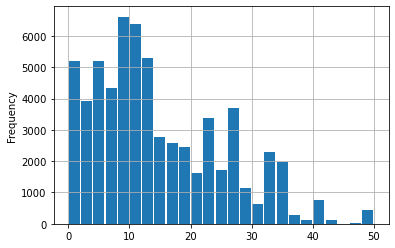

In [19]:
nonice.max_lidar_w.plot.hist(grid=True, bins=25, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

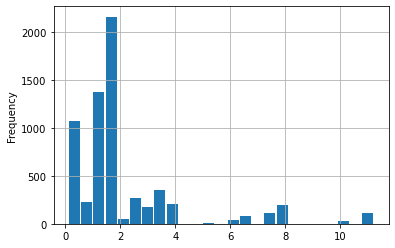

In [20]:
ice.avg_lidar_w.plot.hist(grid=True, bins=25, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

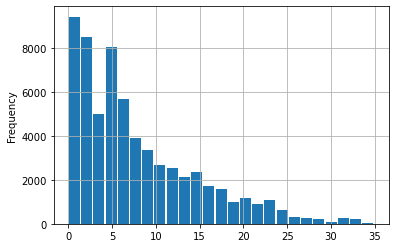

In [21]:
nonice.avg_lidar_w.plot.hist(grid=True, bins=25, rwidth=0.9)

In [22]:
nonice.avg_lidar_w.describe()

count    62942.000000
mean         7.791471
std          6.873556
min          0.000000
25%          2.444444
50%          5.777778
75%         11.444445
max         34.888889
Name: avg_lidar_w, dtype: float64